In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import pandas as pd

In [2]:
# XXX-- a very simple placeholder function. Simple top-hat. Feel free to modify so it's a trapezoid or other shape

def blazar_lc(mjd, filternames, mag, period, platue_time,
              burst_mag, rise_time=0, phase=0):
    
    # XXX--note I'm passing in the filtername info but not using it. Probably want to set some default colors
    # and apply to the results
    result = mjd*0 + mag
    all_phase = (mjd + phase) % period
    
    outbursting = np.where(all_phase <= platue_time)
    result[outbursting] -= burst_mag
    
    return result



    

(17.0, 13.5)

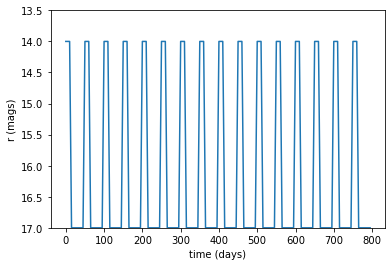

In [3]:
# make sure hte blazar light curve looks ok
mjd = np.arange(0,800, 5)
plt.plot(mjd, blazar_lc(mjd, 'r', 17., 50., 10., 3.))
plt.xlabel('time (days)')
plt.ylabel('r (mags)' )
plt.ylim([17, 13.5])

In [4]:
def generateBlazarSlicer(filename, seed=42):
    """Generate a bunch of blazar objects
    """
    # set the seed so thigns are repeatable
    np.random.seed(seed)
    # read in some data:
    columns = ['ra', 'dec', 'mag', 'period', 'rise_time', 'platue_time', 'burst_mag']
    
    blazar_data = pd.read_csv('blazars.dat', names=columns, comment='#', index_col=False)
    
    slicer = slicers.UserPointsSlicer(blazar_data['ra'].values,
                                      blazar_data['dec'].values,
                                      latLonDeg=True, badval=0)
    # Put all the blazar info into the slicePoint dict
    for col in columns[2:]:
        slicer.slicePoints[col] = blazar_data[col].values
    
    # randomize the phase of each blazar
    slicer.slicePoints['phase'] = blazar_data['period'].values * np.random.uniform(size=slicer.nslice)
    
    return slicer

In [5]:
class BlazarMetric(metrics.BaseMetric):
    """
    """
    
    def __init__(self,  metricName='BlazarMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.saturationCol = 'saturation_mag'
        
        cols = [self.mjdCol, self.m5Col, self.filterCol, self.saturationCol]
        super(BlazarMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Dictionary to hold results
        result = {}
        
        # Generate the lightcurve
        lc = blazar_lc(dataSlice[self.mjdCol], dataSlice[self.filterCol],
                      slicePoint['mag'], slicePoint['period'],
                      slicePoint['platue_time'], slicePoint['burst_mag'],
                      phase=slicePoint['phase'])
        
        # XXX--we could apply dust extintion here. Skipping for now
        
        # Points that are above 5-sigma depth
        diff = lc - dataSlice[self.m5Col]
        bright_enough = np.where(diff < 0)[0]
        
        # Points that saturated
        diff = lc - dataSlice['saturation_mag']
        saturated_indx = np.where(diff < 0)[0]
        unsaturated = np.where(diff > 0)[0]
        
        good_photometry = np.intersect1d(bright_enough, unsaturated)
        # do we detect that this object is variable?
        # I'll use the very simple criteria that we have good photometry that
        # shows a 0.5 mag change in brightness. 
        result['variable_detected'] = 0
        if np.size(good_photometry) > 0:
            if (lc[good_photometry].max() - lc[good_photometry].min()) > 0.5:
                result['variable_detected'] = 1
            
        # Did we saturate
        result['frac_saturated'] = 0
        if np.size(saturated_indx) > 0:
            result['frac_saturated'] = np.size(saturated_indx)/np.size(dataSlice)
            
        # Could add many more criteria. Things like, was it detected early enough to 
        # trigger follow-up events, is there enough data to classify in a timely manner, etc.
      
        return result
    
    # When we calculate multiple values in a metric, give each one a "reduce" method.
    def reduce_detected(self, metric):
        return metric['variable_detected']
    def reduce_saturated(self, metric):
        return metric['frac_saturated']

In [6]:
# conenct to the simulation database
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [7]:
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = BlazarMetric()
slicer = generateBlazarSlicer('blazars.dat')

summaryMetrics=[metrics.MeanMetric(maskVal=0)]
plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryMetrics,
                                             runName=runName))

Querying database SummaryAllProps with no constraint for columns ['visitExposureTime', 'seeingFwhmEff', 'fiveSigmaDepth', 'airmass', 'filter', 'numExposures', 'fieldRA', 'skyBrightness', 'observationStartMJD', 'fieldDec'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_BlazarMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


Plotting complete.


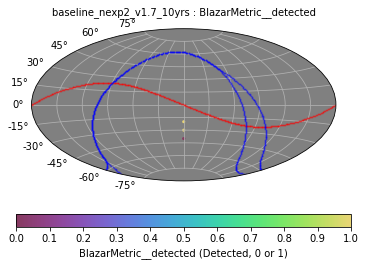

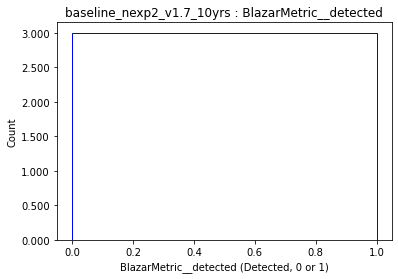

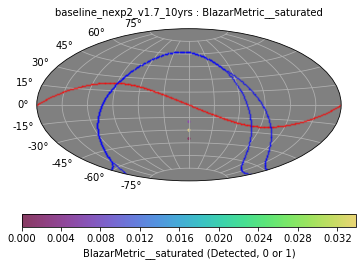

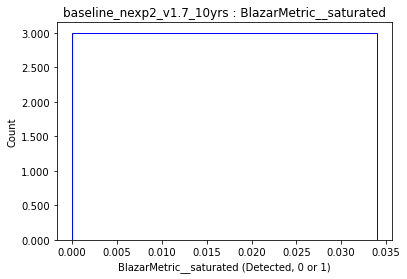

In [8]:


bd = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)



In [9]:
bd

{'baseline_nexp2_v1_7_10yrs_BlazarMetric_USER': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb867c246a0>,
 'BlazarMetric__detected': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb86f01aaf0>,
 'BlazarMetric__saturated': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb86ef96370>}

In [10]:
# We can look at the summary stats. Basically the fraction of objects that got detected as variable, and 
# the mean fraction of saturated points.
bd['BlazarMetric__detected'].summaryValues, bd['BlazarMetric__saturated'].summaryValues

({'Mean': 0.5}, {'Mean': 0.009901396456018305})

# Now let's see what lightcurves looks like

In [11]:
# Let's generate a lightcurve as it was seen
bundleList = []
sql = ''
# Use the PassMetric to just get the data at that point
metric = metrics.PassMetric(cols=['fiveSigmaDepth', 'observationStartMJD','filter'])
slicer = generateBlazarSlicer('blazars.dat')

    
plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=[],
                                             runName=runName))

bd = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)




Querying database SummaryAllProps with no constraint for columns ['filter', 'fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'fieldDec'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Pass_fiveSigmaDepth_observationStartMJD_filter_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [12]:
# Here's all the info obout observations that overlapped that spot in the sky
bundleList[0].metricValues

masked_array(data=[array([('z', 22.8701956 , 3.58867842e+02, 60546.347425  , -20.87119127),
                          ('u', 23.21616806, 3.59018922e+02, 62747.15832206, -21.2938007 ),
                          ('r', 23.98813097, 3.58577998e+02, 60911.24499929, -20.84140202),
                          ('u', 23.31237857, 3.58654368e+02, 61709.13837369, -20.89071499),
                          ('y', 22.09925943, 3.58867842e+02, 60546.36385683, -20.87119127),
                          ('z', 23.07073822, 3.58418382e+02, 62338.31220137, -20.88367014),
                          ('r', 24.3010774 , 3.58971481e+02, 63418.43951074, -20.92295587),
                          ('z', 22.83026647, 3.58529338e+02, 62732.36429688, -20.93819069),
                          ('z', 22.7592126 , 3.58682554e+02, 63199.09958015, -20.83308581),
                          ('r', 24.02701227, 3.58737469e+02, 61330.07940052, -21.20443273),
                          ('y', 21.79613264, 3.58541018e+02, 61248.2855901 , -20

No data for object 3


Text(0, 0.5, 'mags')

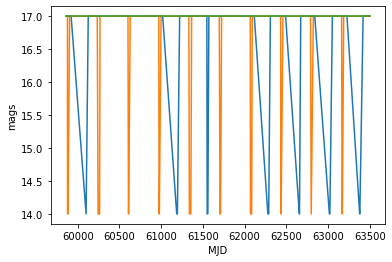

In [20]:
# now we can pass that to the light curve function and see what it looks like
for i,mv in enumerate(bundleList[0].metricValues):
    if np.size(mv) > 1:
        mv.sort(order='observationStartMJD')
        lc = blazar_lc(mv['observationStartMJD'], mv['filter'],
                       slicer.slicePoints['mag'][i], slicer.slicePoints['period'][i],
                       slicer.slicePoints['platue_time'][i],
                      slicer.slicePoints['burst_mag'][i], rise_time=0, phase=slicer.slicePoints['phase'][i])
        plt.plot(mv['observationStartMJD'], lc, label=i)
    else:
        print('No data for object %i' % i)
plt.xlabel('MJD')
plt.ylabel('mags')